## Imports

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
import spacy
import spacy.cli

import numpy as np
import altair as alt
import seaborn as sns

from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from statsmodels.tsa.seasonal import seasonal_decompose

from wordcloud import WordCloud

## Spacy models downloads and imports

In [2]:
#legacy downloads
#spacy.cli.download("en")
#spacy.cli.download("it")

In [3]:
#current way of downloading models
#!python -m spacy download en_core_web_lg
#!python -m spacy download it_core_news_lg

In [4]:
#nltk.download('stopwords')

In [5]:
nlp_en = spacy.load('en_core_web_lg',disable=["tok2vec",  "parser"])
nlp_it = spacy.load('it_core_news_lg',disable=["tok2vec", "parser"])

## Lyrics files loading

In [6]:
DATA = "songlyrics/lyrics"

In [9]:
df = pd.read_csv("songs_with_filenames_and_feats_and_lang_6.csv", delimiter=";")
df = df[df['index'].notna()]

In [10]:
songs = os.listdir(DATA)

In [11]:
print(f"found {len(songs)} unique files") 

found 6671 unique files


In [12]:
#English songs
df_eng = df[df["lang"]=="English"]

In [13]:
#Italian songs
df_it = df[df["lang"]=="Italian"]

In [14]:
data_eng = list()
for song in df_eng["index"]:
    with open(os.path.join(DATA,song),"r",encoding='utf-8') as file:
        lyrics = file.read()
        data_eng.append(lyrics)

In [15]:
data_ita = list()
for song in df_it["index"]:
    with open(os.path.join(DATA,song),"r",encoding='utf-8') as file:
        lyrics = file.read()
        data_ita.append(lyrics)

## Tokenization and lemmatization

In [16]:
#preprocessing function that uses Spacy for lemmatization with parralelization
def preprocess(data, vocabulary, processed_data, nlp_model):
    
    for lyric in nlp_model.pipe(data, n_process=8):
        
        #removing spacy stopwords and non alphanumeric tokens
        lemmas = [tok.lemma_ for tok in lyric if not tok.is_stop and tok.is_alpha]
        cleaned_song = []
        
        #keeping only lemmas of length > 2
        for lemma in lemmas:
            if len(lemma) > 2:
                vocabulary.append(lemma)
                cleaned_song.append(lemma)
                
        processed_data.append(" ".join(cleaned_song))

In [17]:
bag_eng = list() #a bag of words (vocabulary) for english
songs_eng = list() #array of tokenized songs
preprocess(data_eng, bag_eng, songs_eng, nlp_en)

In [18]:
bag_ita = list()
songs_ita = list()
preprocess(data_ita, bag_ita, songs_ita,nlp_it)

## LDA topic modelling

In [43]:
#some extra stopwords lists, language dependant
stop_extra_en = ["la", "yeah", "oh", "ooh", "doo", "da", "gon", "gon", "na", "ayy","ay","La", "woah", "mmm", "nah", "yes","ha","ba","mi", "Ai" "Yeah","huh", "wo", "ah", "ai", "ta", "da", "uh", "ya", "hey", "come", "go", "let", "take", "woo", "til", "o", "e", "eh", "yo"]
stops_en = stopwords.words('english') + stop_extra_en
stop_extra_it = ["ehi", "il", "eh",  "sì", "uoh", "oh", "na", "eh", "qua", "che", "yeah", "poi","solo", "così","qui",'yah', "già",'prima','quel','fra',"quando", "sei", "skrrt", "ora", "mai", "bang", "fare","nun","ogni","forse","però", 'yah',  'uoh', 'brr']
stops_it = stopwords.words('italian') + stop_extra_it

In [44]:
#Vecors of Term Frequencies generation
#we only keep tokens with max corpus frequency <= 70% (max_df=0.7) and minmium frquency of 5 (min_df=5)
tf_vectorizer = CountVectorizer(stop_words = stops_en, lowercase=True, max_df=0.7, min_df=5, max_features = 200, ngram_range=(1,1))
tf = tf_vectorizer.fit_transform(songs_eng)

In [45]:
#We instatiate the LDA model and we train it on our vectors
n_components = 5

lda = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method = 'batch',
                                n_jobs=-1,verbose=1,random_state=7)
lda.fit(tf)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=5, n_jobs=-1, random_state=7, verbose=1)

## Visualizations

In [46]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f'Topic {topic_idx}: '
        message += ', '.join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [47]:
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic 0: dude, dance, man, everybody, party, stop, hands, shake, high, work, right, watch, die, like, dream, young, air, wish, wrong, fly
Topic 1: night, better, says, day, way, time, coming, feel, bloom, old, long, eyes, home, good, world, hand, hear, god, said, know
Topic 2: like, got, know, girl, shit, want, bitch, fuck, think, look, wanna, bad, right, people, time, man, low, said, way, need
Topic 3: baby, wanna, want, tonight, know, time, hold, life, run, boy, away, body, rock, good, need, like, got, right, whoa, night
Topic 4: love, know, heart, feel, got, need, way, mind, time, find, little, away, tell, like, life, gone, touch, change, head, things



In [48]:
doc_topics_en = lda.transform(tf)
# panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
# pyLDAvis.save_html(panel, "topics_2.html")

In [49]:
vocab = tf_vectorizer.get_feature_names()

In [50]:
# Generate a word cloud image for given topic
def draw_word_cloud(index, model, lang, vocab,color):
  imp_words_topic = ""
  comp=model.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:20]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400, background_color=color).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.savefig(f'{lang}_topic_{index}.png')
  plt.show()

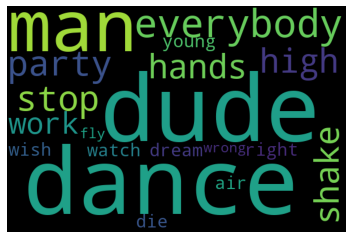

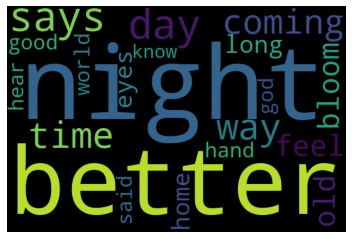

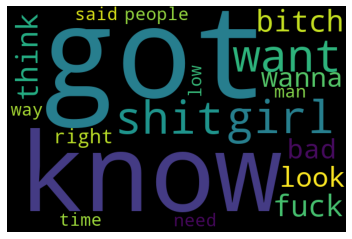

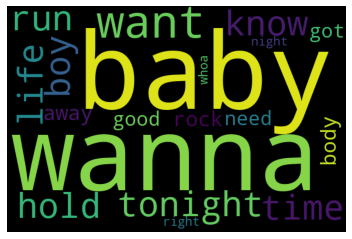

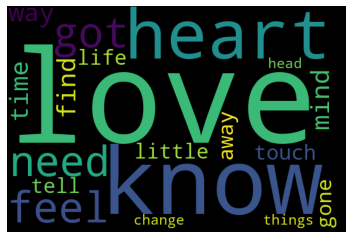

In [51]:
for i in range(5):
    draw_word_cloud(i,lda,"En",vocab,"black")
#party
#rimembranza
#esplicito
#passione
#amore

In [52]:
tf_vectorizer2 = CountVectorizer(stop_words = stops_it, lowercase=True, max_df=0.7, min_df=5, max_features = 200, ngram_range=(1,1))
tf2 = tf_vectorizer2.fit_transform(songs_ita)

In [53]:
n_components = 5

lda2 = LatentDirichletAllocation(n_components=n_components, max_iter=10,
                                learning_method = 'batch',
                                n_jobs=-1,verbose=1,random_state=6)
lda2.fit(tf2)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=5, n_jobs=-1, random_state=6, verbose=1)

In [54]:
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda2, tf_feature_names, n_top_words)

Topic 0: work, talk, bitch, woman, open, shake, bring, free, makes, late, dark, body, day, wanna, sun, fight, going, mean, baby, feel
Topic 1: falling, die, love, lost, work, babe, life, hit, light, wanna, soul, room, shake, white, watch, knew, feeling, music, body, goes
Topic 2: try, damn, sun, shake, hear, mean, guess, touch, good, think, like, listen, right, real, soul, girls, wanna, gone, care, hate
Topic 3: babe, alright, hard, lost, forever, heart, low, young, old, girl, baby, shake, beautiful, falling, sun, away, floor, set, live, mind
Topic 4: shake, work, new, rain, baby, fight, soul, okay, true, eyes, cold, wrong, way, mean, face, walk, alive, hit, real, room



In [55]:
vocab2 = tf_vectorizer2.get_feature_names()

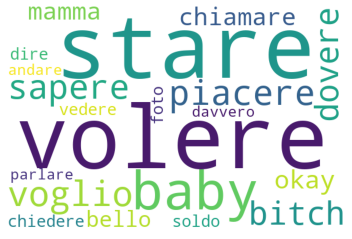

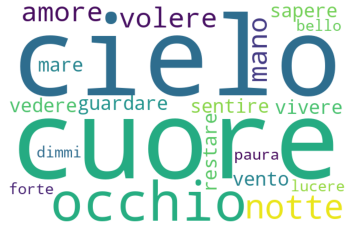

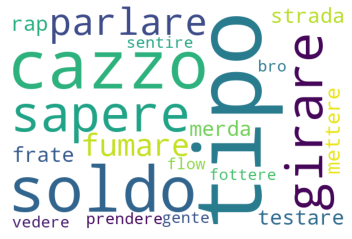

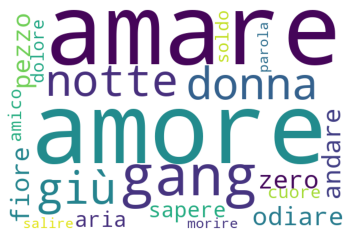

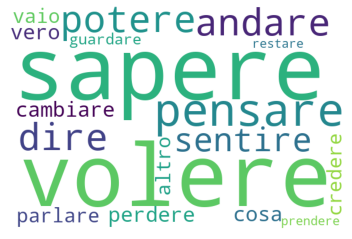

In [56]:
for i in range(5):
    draw_word_cloud(i,lda2,"It",vocab2, "white")
#passione
#esteriore
#parolaccie
#amore
#sentire

In [57]:
preds = np.argmax(doc_topics_en,axis=1)

In [58]:
doc_topics_it = lda2.transform(tf2)

In [59]:
preds_it = np.argmax(doc_topics_it,axis=1)

In [60]:
df.loc[df["lang"] == "English","topic"] = preds
df.loc[df["lang"] == "Italian","topic"] = preds_it

In [61]:
#df.to_csv("test.csv",sep=";")

In [62]:
full_df = pd.read_csv("cleaned_df_v5_with_langs.csv", delimiter=";", parse_dates=True, infer_datetime_format=True)

In [63]:
langdict = df[["id","topic"]].set_index("id").to_dict()["topic"]

In [64]:
full_df["topic"] = full_df["id"].map(langdict)

In [65]:
#full_df.to_csv("cleaned_lang_topics.csv",sep=";",index=False)

In [66]:
italians = full_df[full_df["lang"]=="Italian"]
englishs = full_df[full_df["lang"]=="English"]

In [67]:
topic_counts_eng = englishs.groupby(["date_chart","topic"]).size().unstack(fill_value=0)
topic_counts_eng = topic_counts_eng.div(topic_counts_eng.sum(axis=1), axis=0).reset_index()

In [68]:
topic_counts_it = italians.groupby(["date_chart","topic"]).size().unstack(fill_value=0)
topic_counts_it = topic_counts_it.div(topic_counts_it.sum(axis=1), axis=0).reset_index()

In [69]:
topic_counts_it

topic  date_chart       0.0       1.0       2.0       3.0       4.0
0      2006-05-07  0.000000  0.250000  0.125000  0.000000  0.625000
1      2006-05-14  0.000000  0.333333  0.200000  0.000000  0.466667
2      2006-05-21  0.000000  0.266667  0.200000  0.000000  0.533333
3      2006-05-28  0.000000  0.307692  0.230769  0.000000  0.461538
4      2006-06-04  0.000000  0.285714  0.142857  0.000000  0.571429
..            ...       ...       ...       ...       ...       ...
761    2021-04-22  0.078125  0.406250  0.234375  0.031250  0.250000
762    2021-04-29  0.065574  0.393443  0.163934  0.049180  0.327869
763    2021-05-06  0.046154  0.400000  0.169231  0.030769  0.353846
764    2021-05-13  0.061538  0.384615  0.200000  0.030769  0.323077
765    2021-05-20  0.046875  0.468750  0.093750  0.062500  0.328125

[766 rows x 6 columns]

In [70]:
topic_counts_eng['date_chart'] = pd.to_datetime(topic_counts_eng['date_chart'], format= '%Y-%m-%d')

In [71]:
topic_counts_eng = topic_counts_eng.set_index("date_chart")

In [72]:
#
#rimembranza
#esplicito
#passione
#amore

In [73]:
topics_en = [(topic_counts_eng[0],"party"), (topic_counts_eng[1],"ricordi"), (topic_counts_eng[2],"esplicito"), (topic_counts_eng[3],"passione"),(topic_counts_eng[4],"amore")]
topics_en = list(map(lambda x : (x[0].resample("M").mean(), x[1]),topics_en))
trens_en = list(map(lambda x : (seasonal_decompose(x[0]).trend,x[1]),topics_en))

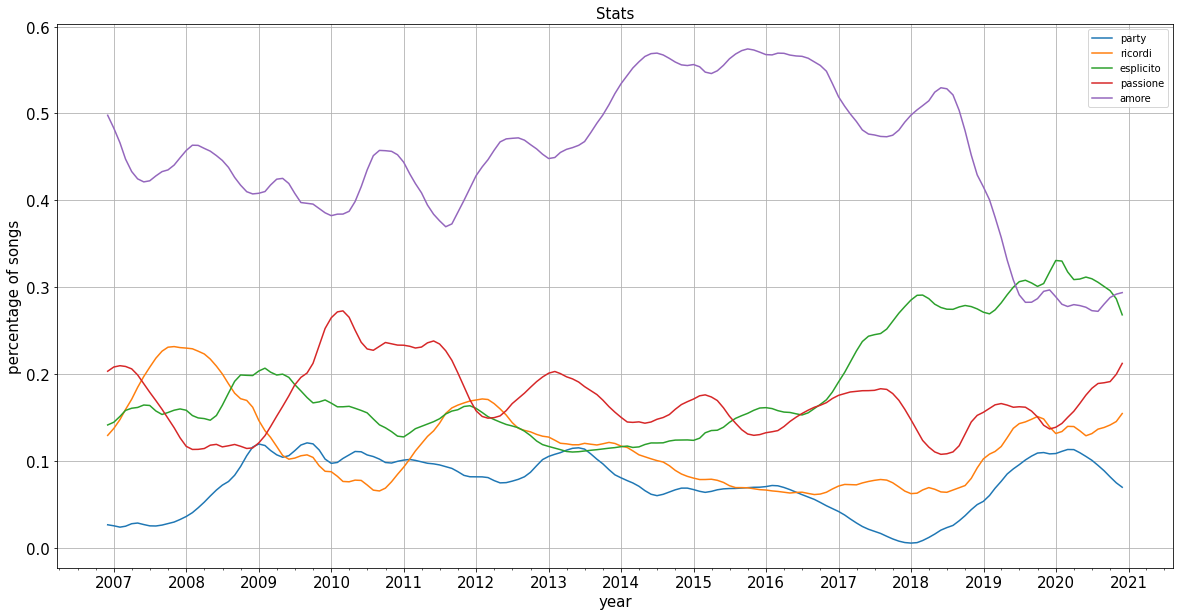

In [74]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

for topic in trens_en: 
    plt.plot(topic[0], label=topic[1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Stats", fontsize=15)
ax.set_xlabel("year", fontsize=15)
ax.set_ylabel("percentage of songs", fontsize=15)

plt.savefig("topics_eng.png", dpi=300)

plt.show()

In [75]:
topic_counts_it['date_chart'] = pd.to_datetime(topic_counts_it['date_chart'], format= '%Y-%m-%d')

In [76]:
topic_counts_it = topic_counts_it.set_index("date_chart")

In [109]:
topic_counts_it

topic            0.0       1.0       2.0       3.0       4.0
date_chart                                                  
2006-05-07  0.000000  0.250000  0.125000  0.000000  0.625000
2006-05-14  0.000000  0.333333  0.200000  0.000000  0.466667
2006-05-21  0.000000  0.266667  0.200000  0.000000  0.533333
2006-05-28  0.000000  0.307692  0.230769  0.000000  0.461538
2006-06-04  0.000000  0.285714  0.142857  0.000000  0.571429
...              ...       ...       ...       ...       ...
2021-04-22  0.078125  0.406250  0.234375  0.031250  0.250000
2021-04-29  0.065574  0.393443  0.163934  0.049180  0.327869
2021-05-06  0.046154  0.400000  0.169231  0.030769  0.353846
2021-05-13  0.061538  0.384615  0.200000  0.030769  0.323077
2021-05-20  0.046875  0.468750  0.093750  0.062500  0.328125

[766 rows x 5 columns]

In [77]:
#passione
#esteriore
#parolaccie
#amore
#sentire

In [78]:
topics_it = [(topic_counts_it[0],"passione"), (topic_counts_it[1],"esteriore"), (topic_counts_it[2],"esplicito"), (topic_counts_it[3],"amore"),(topic_counts_it[4],"sentire")]
topics_it = list(map(lambda x : (x[0].resample("M").mean(), x[1]),topics_it))
trens_it = list(map(lambda x : (seasonal_decompose(x[0]).trend,x[1]),topics_it))

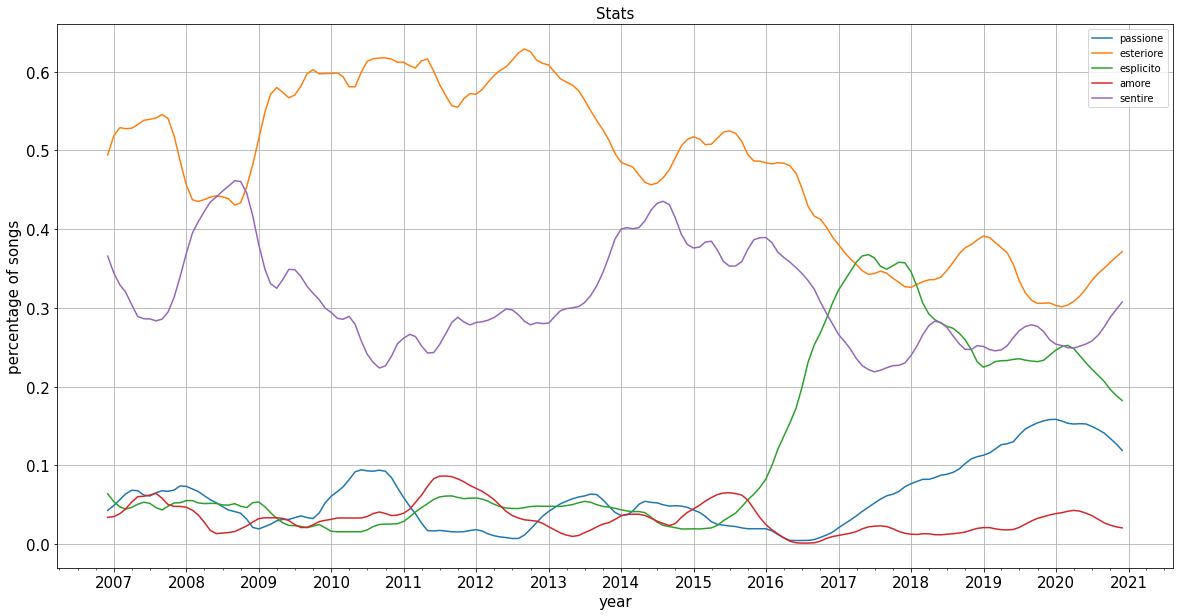

In [79]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

for topic in trens_it: 
    plt.plot(topic[0], label=topic[1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Stats", fontsize=15)
ax.set_xlabel("year", fontsize=15)
ax.set_ylabel("percentage of songs", fontsize=15)

plt.savefig("topics_it.png", dpi=300)

plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [5], 'learning_decay': [.7]}

# Init the model
lda = LatentDirichletAllocation()

# Init Grid Search class
model = GridSearchCV(lda, search_params,n_jobs=-1)

model.fit(tf)
best_lda_model = model.best_estimator_
print("Best model's params: ", model.best_params_)
print("Best log likelihood score: ", model.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(tf))

Best model's params:  {'learning_decay': 0.7, 'n_components': 5}
Best log likelihood score:  -145215.28644735558
Model perplexity:  155.50075755203258


In [ ]:
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, n_top_words)

Topic 0: niente, sai, tempo, giorno, giù, ancora, amo, senza, vivere, mondo, sempre, fine, cielo, fino, odio, sento, mentre, paura, altro, bisogno
Topic 1: soldi, gang, cazzo, fumo, sempre, sopra, tipo, frate, fuori, bitch, fatto, rap, vuole, giro, merda, okay, flow, bro, brr, bella
Topic 2: casa, stare, posso, sento, testa, male, fuori, oggi, pure, vai, sotto, strada, posto, cose, vedo, perso, dico, fatto, dentro, zero
Topic 3: senza, vita, amore, sempre, notte, cuore, mondo, dentro, occhi, sole, ancora, mare, cielo, può, parole, tempo, dimmi, volta, vorrei, adesso
Topic 4: cosa, voglio, bene, vuoi, ancora, adesso, tanto, male, meglio, sempre, sai, baby, dire, penso, vero, vieni, vita, ciò, fatto, dentro



In [ ]:
doc_topics = best_lda_model.transform(tf)

In [ ]:
preds = np.argmax(doc_topics,axis=1)

In [ ]:
panel = pyLDAvis.sklearn.prepare(best_lda_model, tf, tf_vectorizer, mds='tsne')
#pyLDAvis.save_html(panel, "topics_bello.html")

In [ ]:
import pickle

In [ ]:
#pkl_filename = "topics_ita.pkl"
#with open(pkl_filename, 'wb') as file:
    #pickle.dump(best_lda_model, file)

In [ ]:
df_eng["topic"] = preds

In [ ]:
points = alt.Chart(df_it).mark_circle(
    opacity=0.8,
    size=100
).encode(
    x='TSNE_x',
    y='TSNE_y',
    tooltip=["song_name", "artists_names", "album_release_date", "tag_fimi","publisher","album_release_date", "lang", "intros", "topic"],
    color=alt.Color('topic:N')
)
'''
text = points.mark_text(
    align='left',
    baseline='middle',
    dx=7
).encode(
    text='publisher'
)
'''
al = points# + text
al.interactive().properties(
    width=1920,
    height=1080
)

alt.Chart(...)

In [ ]:
points = alt.Chart(df_eng).mark_circle(
    opacity=0.8,
    size=100
).encode(
    x='TSNE_x',
    y='TSNE_y',
    tooltip=["song_name", "artists_names", "album_release_date", "tag_fimi","publisher","album_release_date", "lang", "intros", "topic"],
    color=alt.Color('topic:N')
)
'''
text = points.mark_text(
    align='left',
    baseline='middle',
    dx=7
).encode(
    text='publisher'
)
'''
al = points# + text
al.interactive().properties(
    width=1920,
    height=1080
)

alt.Chart(...)

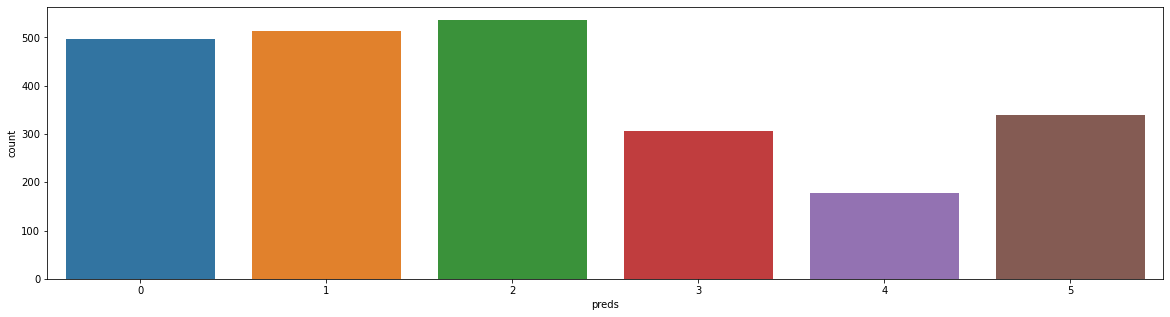

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="preds", data=pd.DataFrame(preds,columns=["preds"]))

In [ ]:
panel = pyLDAvis.sklearn.prepare(best_lda_model, tf, tf_vectorizer, mds='tsne')
pyLDAvis.save_html(panel, "topicsb.html")

In [ ]:
100 50 100 

In [103]:
def get_count(lyrics):
    output = list()
    for lyric in lyrics:
        tokens = lyric.split(" ")
        output.append(len(set(tokens)))
    return output

In [191]:
full_df = pd.read_csv("cleaned_df_v5_with_langs.csv", delimiter=";", parse_dates=True, infer_datetime_format=True)

In [192]:
df.loc[df["lang"] == "English","count_lemms"] = get_count(songs_eng)
df.loc[df["lang"] == "Italian","count_lemms"] = get_count(songs_ita)

In [193]:
lendict = df[["id","count_lemms"]].set_index("id").to_dict()["count_lemms"]

In [194]:
full_df["count_lemms"] = full_df["id"].map(lendict)

In [189]:
italian_lens = full_df[full_df["lang"]=="Italian"]
englishs_lens = full_df[full_df["lang"]=="English"]

In [200]:
lens_eng = englishs_lens.groupby(["date_chart"])["count_lemms"].mean()
lens_ita = italian_lens.groupby(["date_chart"])["count_lemms"].mean()

In [225]:
frame_en = pd.DataFrame(lens_eng).reset_index()
frame_en['date_chart'] = pd.to_datetime(frame_en['date_chart'], format= '%Y-%m-%d')
frame_en = frame_en.set_index("date_chart")
frame_en = frame_en.resample("M").mean()
frame_en = pd.DataFrame(frame_en).reset_index()
frame_en['date_chart'] = pd.to_datetime(frame_en['date_chart'], format= '%Y-%m-%d')
frame_en = frame_en.set_index("date_chart")

In [226]:
frame_it = pd.DataFrame(lens_ita).reset_index()
frame_it['date_chart'] = pd.to_datetime(frame_it['date_chart'], format= '%Y-%m-%d')
frame_it = frame_it.set_index("date_chart")
frame_it = frame_it.resample("M").mean()
frame_it = pd.DataFrame(frame_it).reset_index()
frame_it['date_chart'] = pd.to_datetime(frame_it['date_chart'], format= '%Y-%m-%d')
frame_it = frame_it.set_index("date_chart")

In [229]:
langs = [(frame_en, "English"), (frame_it, "Italian")]
trends_lens = list(map(lambda x : (seasonal_decompose(x[0]).trend,x[1]),langs))

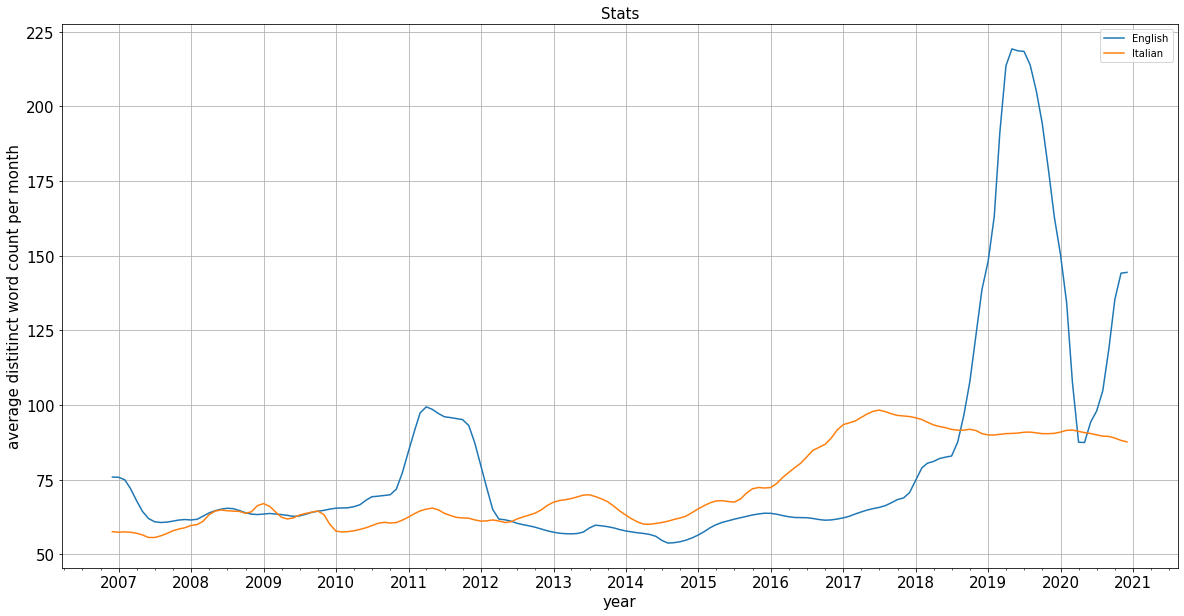

In [231]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

for topic in trends_lens: 
    plt.plot(topic[0], label=topic[1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Trend of distinct word count", fontsize=15)
ax.set_xlabel("year", fontsize=15)
ax.set_ylabel("distinct word count", fontsize=15)

plt.savefig("topics_it.png", dpi=300)

plt.show()

In [2]:
from nrclex import NRCLex

In [26]:
text_object = NRCLex(songs_eng[0])

In [30]:
text_object.affect_frequencies

{'fear': 0.05405405405405406,
 'anger': 0.02702702702702703,
 'anticip': 0.0,
 'trust': 0.13513513513513514,
 'surprise': 0.05405405405405406,
 'positive': 0.1891891891891892,
 'negative': 0.21621621621621623,
 'sadness': 0.05405405405405406,
 'disgust': 0.02702702702702703,
 'joy': 0.10810810810810811,
 'anticipation': 0.13513513513513514}

In [31]:
eng_affect = [NRCLex(song).affect_frequencies for song in songs_eng]

In [34]:
eng_affect = pd.DataFrame(eng_affect)

In [105]:
len(eng_affect)

2386

In [177]:
result = pd.concat([df_eng.reset_index()["id"], eng_affect], axis=1)

In [178]:
result

id      fear     anger  anticip     trust  surprise  \
0     1HOlb9rdNOmy9b1Fakicjo  0.054054  0.027027      0.0  0.135135  0.054054   
1     01TuObJVd7owWchVRuQbQw  0.040404  0.010101      0.0  0.222222  0.010101   
2     4eeuuTvT8IpQiR0UXsWzrE  0.094340  0.075472      0.0  0.094340  0.018868   
3     4BFMQ15vXr626UOoZL8bUI  0.038462  0.012821      0.0  0.243590  0.051282   
4     2yLa0QULdQr0qAIvVwN6B5  0.150000  0.050000      0.0  0.000000  0.016667   
...                      ...       ...       ...      ...       ...       ...   
2381  3Uo7WG0vmLQ07WB4BDwy7D  0.105263  0.078947      0.0  0.043860  0.105263   
2382  3Fj47GNK2kUF0uaEDgXLaD  0.139535  0.069767      0.0  0.023256  0.046512   
2383  4QIo4oxwzzafcBWkKjDpXY  0.121951  0.085366      0.0  0.048780  0.036585   
2384  3XF5xLJHOQQRbWya6hBp7d  0.190476  0.031746      0.0  0.095238  0.015873   
2385  0vyQzGo4ZhrOvp0zMkpyLP  0.125000  0.012500      0.0  0.187500  0.012500   

      positive  negative   sadness   disgust       joy  anticipation  
0     0.189189  0.216216  0.054054  0.027027  0.108108      0.135135  
1     0.232323  0.050505  0.020202  0.010101  0.202020      0.202020  
2     0.018868  0.264151  0.188679  0.188679  0.018868      0.037736  
3     0.294872  0.025641  0.012821  0.025641  0.115385      0.179487  
4     0.183333  0.150000  0.066667  0.066667  0.150000      0.166667  
...        ...       ...       ...       ...       ...           ...  
2381  0.070175  0.263158  0.149123  0.078947  0.035088      0.070175  
2382  0.139535  0.255814  0.162791  0.023256  0.093023      0.046512  
2383  0.121951  0.268293  0.121951  0.060976  0.073171      0.060976  
2384  0.126984  0.142857  0.079365  0.031746  0.111111      0.174603  
2385  0.287500  0.050000  0.012500  0.000000  0.162500      0.150000  

[2386 rows x 12 columns]

In [190]:
full_df = pd.read_csv("cleaned_df_v5_with_langs.csv", delimiter=";", parse_dates=True, infer_datetime_format=True)

In [191]:
full_df = full_df.set_index('id').join(result.set_index('id'))

In [199]:
englishs = full_df[full_df["lang"]=="English"].reset_index()
englishs['date_chart'] = pd.to_datetime(englishs['date_chart'], format= '%Y-%m-%d')
englishs = englishs.set_index("date_chart")
englishs = englishs.resample("M").mean()

In [217]:
sentiments = ['fear', 'anger', 'anticipation', 'trust','surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy']


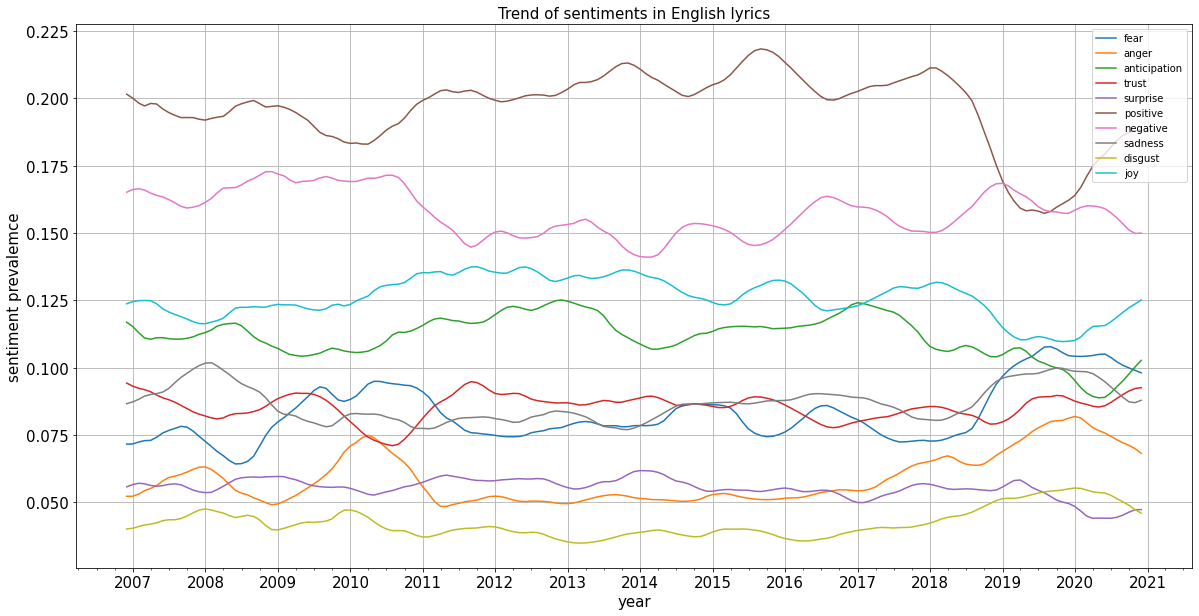

In [221]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

for sent in sentiments: 
    plt.plot(seasonal_decompose(englishs[sent]).trend, label=sent)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Trend of sentiments in English lyrics", fontsize=15)
ax.set_xlabel("year", fontsize=15)
ax.set_ylabel("sentiment prevalemce", fontsize=15)

#plt.savefig("topics_it.png", dpi=300)

plt.show()